<a href="https://colab.research.google.com/github/oliveoil212/PairTrading/blob/main/pairtrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install riskfolio-lib
!pip install backtrader
!pip install yfinance

In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yfinance as yf
import statsmodels.api as sm
import riskfolio as rp
from dateutil.relativedelta import relativedelta

from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split
import backtrader as bt

In [12]:
start = '2012-01-01'
end = '2023-12-12'

Top = ['ABNB','MU','ADP','ETN','DE','ELV','MDT','SBUX','BMY','TJX','VRTX','LRCX','CVS','GS','BKNG','NEE','BLK','T','ISRG','SYK','LMT','JNJ','PG','COST','ADBE','BAC','PM','NOW','GE','LOW','UBER','SCHW','GS','NEE','T','SYK','ISRG','HON','ORCL','AMX','PSX','NXPI','APH','PH','AON','MMM','MPC','CMG','TEAM','BN','SMFG','FDX','PNC','CRWD','FCX','APD','MCK','PGR','ZTS','SBUX','BMY','TJX', 'LRCX','CVS','GILD','SHOP','ADI','C','PANW','TSLA','AMD','NFLX','MCD','CSCO','NKE','BA','VZ','AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'META', 'UNH', 'XOM', 'LLY', 'JPM', 'JNJ', 'V', 'PG', 'MA', 'AVGO', 'HD', 'CVX', 'MRK', 'ABBV', 'COST', 'PEP', 'ADBE']
Top.sort()
top_all = yf.download(Top, start = start, end = end)
##########################################################################################################################


[*********************100%%**********************]  85 of 85 completed


In [13]:

########################################################################
### ADD
# Get Cluster pairs from rp
# try writing Class object to plot relevant plots easily
# option for cluster method

########################################################################
def get_topN(cap, n):
    top_list = pd.to_numeric(cap.iloc[0], errors='coerce').nlargest(n).index.tolist()
    return top_list

def yfInfo_convert_long(df):
    df.reset_index(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.dropna(inplace=True)
    data_long = pd.melt(df, id_vars=[('Date', '')], var_name=['Metric', 'Ticker'])

    data_long.columns = ['Date', 'Metric', 'Ticker', 'Value']# Rename columns
    data_long = data_long.pivot_table(index=['Date', 'Ticker'], columns='Metric', values='Value').reset_index()# Pivot the DataFrame to rearrange the data
    data_long.columns.name = None# Reset column names

    data_long = data_long.sort_values(by='Ticker').reset_index(drop=True) #Sorting
    data_long = data_long[['Ticker', 'Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']]
    data_long.set_index(['Ticker', 'Date'], inplace=True)
    data_long.sort_index(level=['Ticker', 'Date'], inplace=True)
    data_long.apply(pd.to_numeric, errors='coerce')

    return data_long

def back_test_results(weights, data_long, startcash):
    assets_param = [(ind, weights.loc[ind][0]) for ind in weights.index]
    #print(assets_param)
    tickers = data_long.index.get_level_values(0).unique()
    ### Initial Settings ###
    #startcash = 1000000
    commission = 0

    cerebro = bt.Cerebro() #Create an instance of cerebro
    cerebro.broker.setcash(startcash)
    cerebro.broker.set_checksubmit(False) # orders will not be checked to see if you can afford it before submitting them
    cerebro.broker.setcommission(commission=commission)

    for ticker, datas in data_long.groupby(level=0):
        if ticker in tickers:
            #print(f"Adding ticker: {ticker}")
            data_bt = bt.feeds.PandasData(dataname=datas.droplevel(level=0),
                                    name=str(ticker),
                                    fromdate=data_long.index[0][1], #datetime.strptime(start, '%Y-%m-%d'),
                                    todate=data_long.index[-1][1], #datetime.strptime(end, '%Y-%m-%d'),
                                    plot=False)
            cerebro.adddata(data_bt)

    cerebro.addstrategy(Strategy, assets=assets_param)
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

    # print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    results = cerebro.run(stdstats=True, tradehistory=False)
    # print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Result
    strat = results[0]
    pyfoliozer = strat.analyzers.getbyname('pyfolio')
    returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
    returns.name = 'Strategy'
    # cerebro.plot()
    # Portfolio Value
    portfolio_value = returns.cumsum().apply(np.exp) * startcash

    return returns, portfolio_value


def pair_strategy(cluster_method, price):
    rt = price.pct_change().dropna()
    wt_dict = {key: 0 for key in rt.columns}
    if cluster_method == 'Hierarchical':
        clusters = rp.assets_clusters(returns=rt,
                                    codependence='spearman',
                                    linkage='average',
                                    k=None,
                                    max_k=10,
                                    leaf_order=False)
        clusters = clusters.sort_values(by='Clusters')
    elif cluster_method == 'Hierarchical2':
        clusters = rp.assets_clusters(returns=rt,
                                    codependence='spearman',
                                    linkage='complete',
                                    k=None,
                                    max_k=10,
                                    leaf_order=False)
        clusters = clusters.sort_values(by='Clusters')
    elif cluster_method == 'Hierarchical3':
        clusters = rp.assets_clusters(returns=rt,
                                    codependence='spearman',
                                    linkage='ward',
                                    k=None,
                                    max_k=10,
                                    leaf_order=False)
        clusters = clusters.sort_values(by='Clusters')

    elif cluster_method == 'Hierarchical4':
        clusters = rp.assets_clusters(returns=rt,
                                    codependence='spearman',
                                    linkage='single',
                                    k=None,
                                    max_k=10,
                                    leaf_order=False)
        clusters = clusters.sort_values(by='Clusters')
    elif cluster_method == 'Hierarchical5':
        clusters = rp.assets_clusters(returns=rt,
                                    codependence='abs_spearman',
                                    linkage='average',
                                    k=None,
                                    max_k=10,
                                    leaf_order=False)
        clusters = clusters.sort_values(by='Clusters')
    elif cluster_method == 'Hierarchical6':
        clusters = rp.assets_clusters(returns=rt,
                                    codependence='mutual_info',
                                    linkage='average',
                                    k=None,
                                    max_k=10,
                                    leaf_order=False)
        clusters = clusters.sort_values(by='Clusters')
    elif cluster_method == 'Hierarchical7':
        clusters = rp.assets_clusters(returns=rt,
                                    codependence='tail',
                                    linkage='average',
                                    k=None,
                                    max_k=10,
                                    leaf_order=False)
        clusters = clusters.sort_values(by='Clusters')
        # print(clusters)
    elif cluster_method == 'SOM':
        clusters = 'non'

    pair_df = pd.DataFrame(columns=['High', 'Low', 'Diff'])
    all_clust = clusters['Clusters'].unique()
    for cluster in all_clust:

        clust = clusters[clusters['Clusters'] == cluster]
        clust = clust['Assets'].to_list()
        sub = rt[clust]

        sub_rt = sub.resample('M').sum()
        last_rt = sub_rt[-1:].T
        last_rt.columns = ['Month_Return']
        last_rt = last_rt.sort_values(by='Month_Return', ascending=False)
        sort = last_rt.index

        for i in range(round(len(sort)/2)):
            pair_list = list()
            low_index = len(sort)-i-1
            diff = last_rt.T[sort[i]] - last_rt.T[sort[low_index]]
            pair_list.append(sort[i])
            pair_list.append(sort[low_index])
            pair_list.append(diff.values[0])
            pair_df = pair_df._append(pd.Series(pair_list, index=pair_df.columns), ignore_index=True)

    final = pair_df[pair_df['Diff'] > pair_df['Diff'].std()]

    for index, row in final.iterrows():
        wt_dict[row['High']] = -1/len(final)
        wt_dict[row['Low']] = 1/len(final)

    optimal_weight = pd.DataFrame([wt_dict],columns=wt_dict.keys()).T * 100

    return optimal_weight

def pair_roll_test(cluster_method, price, rolling_window=6):
    wt_all = pd.DataFrame()
    rets = pd.Series(dtype=np.float64)
    values = pd.Series(1)
    rolling_window = relativedelta(months = rolling_window)
    roll = relativedelta(months = 1)
    end = price.index[0] + rolling_window
    mons = price.index.strftime('%Y-%m').nunique() #Get Total Month in price df

    print('Start Roll Testing...')
    for i in range(mons-2):
        start = end - rolling_window
        train = price[
            (price.index.strftime('%Y-%m') >= start.strftime('%Y-%m')) &
            (price.index.strftime('%Y-%m') < end.strftime('%Y-%m'))
            ]
        train = train.dropna(axis=1)
        train_set = train.loc[:,('Adj Close', slice(None))]
        train_set.columns = train_set.columns.get_level_values(1)

        # drop unchange value columns
        const_col = train_set.columns[train_set.nunique()==1]
        train_set = train_set.drop(columns=const_col)
        drop_ticker = train.columns[train.columns.get_level_values(1).isin(const_col)]

        wt = pair_strategy(cluster_method, train_set)
        wt_all = pd.concat([wt_all, wt],axis=1)
        # wt_all[end.strftime('%Y-%m')] = wt
        # print(wt)
        train = train.drop(columns=drop_ticker)
        remains = train.columns
        test_set = price[
            (price.index.strftime('%Y-%m') >= end.strftime('%Y-%m')) &
            (price.index.strftime('%Y-%m') < (end+roll).strftime('%Y-%m'))
            ]
        test_set = test_set[remains]
        data_long = yfInfo_convert_long(test_set) # Reformat data
        ini_val = values.iloc[-1] * 1000000
        rt, val = back_test_results(wt, data_long, ini_val)
        rets = pd.concat([rets, rt])
        values = pd.concat([values, val/1000000])
        end += roll

        if (end.strftime('%Y-%m') > price.index[-1].strftime('%Y-%m')) == True:
            break
        # else:
        #     continue
    values = values[1:]
    values.index = pd.to_datetime(values.index)

    rets.name = f'{cluster_method}'
    values.name = f'{cluster_method}'
    return rets, values, wt_all

class Strategy(bt.Strategy):
    # parameters for inputs
    params = dict(
        assets = [],
        rebalance_months = list(range(1, 13))
    )
    # initialize
    def __init__(self):
        # create a dictionary of ticker:{'rebalanced': False, 'target_percent': target%}
        self.rebalance_dict = dict()
        for i, d in enumerate(self.datas):
            self.rebalance_dict[d] = dict()
            self.rebalance_dict[d]['rebalanced'] = False
            for asset in self.p.assets:
                if asset[0] == d._name:
                    self.rebalance_dict[d]['target_percent'] = asset[1]

    def next(self):
        # rebalance for the month in the list
        for i, d in enumerate(self.datas):
            dt = d.datetime.datetime()
            dname = d._name
            pos = self.getposition(d).size

            if dt.month in self.p.rebalance_months and self.rebalance_dict[d]['rebalanced'] == False:
                # print('{} Sending Order: {:6s} | Month {} | Rebalanced: {} | Pos: {}'.
                #       format(dt, dname, dt.month,
                #              self.rebalance_dict[d]['rebalanced'], pos ))

                self.order_target_percent(d, target=self.rebalance_dict[d]['target_percent']/100)
                self.rebalance_dict[d]['rebalanced'] = True

            # Reset the flage
            elif dt.month not in self.p.rebalance_months:
                self.rebalance_dict[d]['rebalanced'] = False

    # notify the order if completed
    def notify_order(self, order):
        date = self.data.datetime.datetime().date()
        # if order.status == order.Completed:
            # print('{} >> Order Completed >> Stock: {},  Ref: {}, Size: {}, Price: {}'.
            #       format(date, order.data._name, order.ref, order.size,
            #              'NA' if not order.price else round(order.price,5)
            #             ))

    # notify the trade if completed
    def notify_trade(self, trade):
        date = self.data.datetime.datetime().date()
        # if trade.isclosed:
            # print('{} >> Notify Trade >> Stock: {}, Close Price: {}, Profit, Gross {}, Net {}'.
            #       format(date, trade.data._name, trade.price, round(trade.pnl,2),round(trade.pnlcomm,2))
            #      )






Start Roll Testing...


<ipython-input-13-28a88f014bad>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])
<ipython-input-13-28a88f014bad>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
<ipython-input-13-28a88f014bad>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd

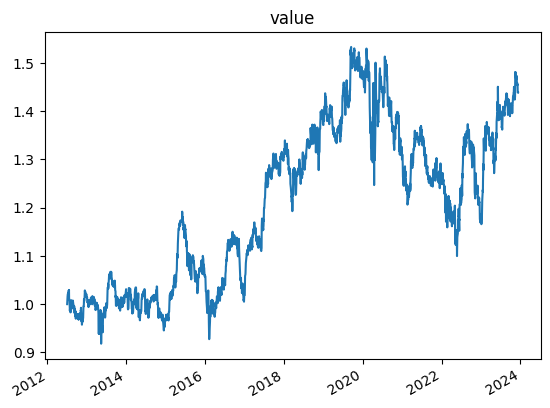

In [14]:

us_pair_rt, us_pair_val, us_pair_wt = pair_roll_test('Hierarchical', top_all)
plot = us_pair_val.plot(title="value")

Start Roll Testing...


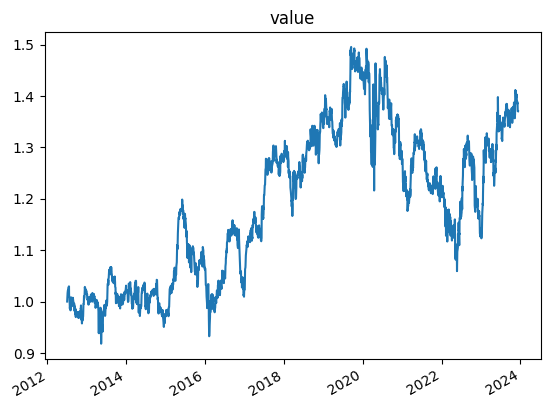

In [15]:

us_pair_rt, us_pair_val, us_pair_wt = pair_roll_test('Hierarchical5', top_all)
plot = us_pair_val.plot(title="value")

In [16]:
# type(pd.Series(us_pair_val))
type(us_pair_rt)

pandas.core.series.Series

In [17]:
us_pair_wt

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAPL,5.555556,-9.090909,-5.882353,0.0,7.692308,0.000000,0.000000,8.333333,6.666667,-5.0,...,0.000000,-5.882353,0.000000,0.000000,0.000000,4.166667,0.000000,4.761905,0.000000,0.00
ADBE,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-6.666667,8.333333,0.000000,-5.0,...,5.882353,-5.882353,0.000000,-4.761905,-5.263158,-4.166667,0.000000,4.761905,-5.263158,0.00
ADI,0.000000,-9.090909,0.000000,5.0,0.000000,0.000000,0.000000,8.333333,0.000000,0.0,...,-5.882353,0.000000,6.666667,0.000000,0.000000,4.166667,5.263158,0.000000,5.263158,0.00
ADP,-5.555556,0.000000,0.000000,0.0,0.000000,4.545455,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,4.761905,0.000000,-4.166667,-5.263158,0.000000,5.263158,6.25
AMD,5.555556,9.090909,5.882353,5.0,7.692308,-4.545455,-6.666667,0.000000,0.000000,0.0,...,-5.882353,-5.882353,6.666667,-4.761905,5.263158,4.166667,5.263158,0.000000,0.000000,-6.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SHOP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.882353,-5.882353,0.000000,-4.761905,-5.263158,0.000000,0.000000,4.761905,5.263158,-6.25
TEAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,6.666667,-4.761905,5.263158,0.000000,-5.263158,-4.761905,5.263158,6.25
UBER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.882353,5.882353,0.000000,-4.761905,-5.263158,-4.166667,0.000000,0.000000,0.000000,-6.25
CRWD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.882353,-5.882353,6.666667,-4.761905,5.263158,-4.166667,0.000000,-4.761905,-5.263158,-6.25


In [18]:
# start = '2013-01-01'
# end = '2023-06-01'

# ###### Top Stocks ######
# mk_cap_file = r'/Users/mktCap.xlsx'
# mkCap = pd.read_excel(mk_cap_file)
# new_columns = {col: col.split(' ')[0] + '.TW' for col in mkCap.columns[1:]}
# mkCap = mkCap.rename(columns=new_columns)
# tw_topN = get_topN(mkCap, 150)
# tw_top = yf.download(tw_topN, start = start, end = end)

# tw_top_all = yf.download(tw_topN, start = start, end = end)
# tw_top_all = tw_top_all.loc[tw_top.index]
# tw_top_all.drop(['2014-07-23'], inplace=True)
# tw_close = tw_top.loc[:,('Adj Close', slice(None))]

# tw_pair_rt, tw_pair_val, tw_pair_wt = pair_roll_test('Hierarchical', tw_top)